In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import sys
sys.path.append("../")
from models.topics import TopicExtractionModel
from sentence_transformers import SentenceTransformer

In [2]:
headlines = pd.read_json("../data/raw/headlines.json", lines=True)
headline_embeddings = pd.read_parquet("../data/headline_embeddings.parquet")
headlines_merged = pd.merge(headlines, headline_embeddings, on="id", how="left")

In [93]:
from models.topics import NonStationaryFilter, HighKurtosisFilter, CompoundFilter
YEAR = 1977
sample_year = headlines_merged[headlines_merged["year"] == YEAR]

model = SentenceTransformer("all-MiniLM-L6-v2")
ns_filter = NonStationaryFilter(pvalue_threshold=0.1, n_periods=3)
kt_filter = HighKurtosisFilter(kurtosis_threshold=2)
compound_filter = CompoundFilter([ns_filter, kt_filter])
tm = TopicExtractionModel(model, topic_filter=compound_filter)
tm.fit(sample_year["headline"].tolist(), np.stack(sample_year["embedding"].tolist()), sample_year["month"].tolist())


In [94]:
tm.model.visualize_topics_over_time(tm.topics_over_time[tm.topics_over_time.Topic.isin(tm.topic_filter.topics)])

In [96]:
tm.compute_alignment(tm.centroids, p=4, mod_sim=True)

array([1.1053858, 1.0250453, 1.0715128, 1.0744487, 1.0562075, 1.0322287,
       1.0284439, 1.0852964, 1.1170399, 1.0678169, 1.026485 , 1.1248631,
       1.0299671, 1.0279695, 1.0192293], dtype=float32)

In [97]:
novels = pd.read_csv("../data/nominated_novels.csv")
description_embeddings = pd.read_parquet("../data/description_embeddings.parquet")
desc_merged = pd.get_dummies(novels[novels.year == YEAR], columns=['gender']).merge(description_embeddings, on="work_qid", how="left").groupby("work_qid").agg({
    'age': 'mean',
    'awards_as_of_year': 'sum',
    'embedding': 'first',
    'n_win': 'first',
    'n_nom': 'first',
    'gender_male': 'sum',
    'gender_female': 'sum',
}).dropna()

desc_merged.count()

age                  10
awards_as_of_year    10
embedding            10
n_win                10
n_nom                10
gender_male          10
gender_female        10
dtype: int64

In [101]:
from models.debias import NullspaceProjector, learn_nullspace_normal_vector

train_desc = pd.read_csv("../data/train_desc_labeled.csv")
w = learn_nullspace_normal_vector(train_desc)
db = NullspaceProjector(normal_vector=w)
embeddings = db.transform(np.stack(desc_merged["embedding"].values))
db.fit(embeddings)
desc_aligned = desc_merged.assign(
    cosine=tm.compute_alignment(embeddings, metric="cosine"),
    linear=tm.compute_alignment(embeddings, metric="linear"),
    rbf=tm.compute_alignment(embeddings, metric="rbf", gamma=5),
).melt(
    value_vars=["cosine", "linear", "rbf"],
    value_name="alignment",
    var_name="metric",
    ignore_index=False,
).join(desc_merged, how="left").assign(won=lambda x: x.n_win > 0)
desc_aligned.head()

,metric,alignment,age,awards_as_of_year,embedding,n_win,n_nom,gender_male,gender_female,won
work_qid,,,,,,,,,,
Q122452523,cosine,0.322850,29.0,0,"[-0.026827814, 0.040379934, 0.03314715, 0.0314...",0,1,0,1,False
Q1448428,cosine,0.324884,54.0,11,"[-0.057265908, 0.11394991, 0.01380519, 0.04636...",0,1,1,0,False
Q2377008,cosine,0.315074,58.0,12,"[-0.025931792, 0.017050132, 0.024950795, -0.01...",1,2,1,0,True
Q3135306,cosine,0.432386,49.0,10,"[-0.012680732, -0.046038665, -0.0124388505, 0....",1,2,0,1,True
Q3224982,cosine,0.315670,38.0,1,"[-0.02369637, 0.10994188, -0.0010569477, 0.013...",0,1,1,0,False


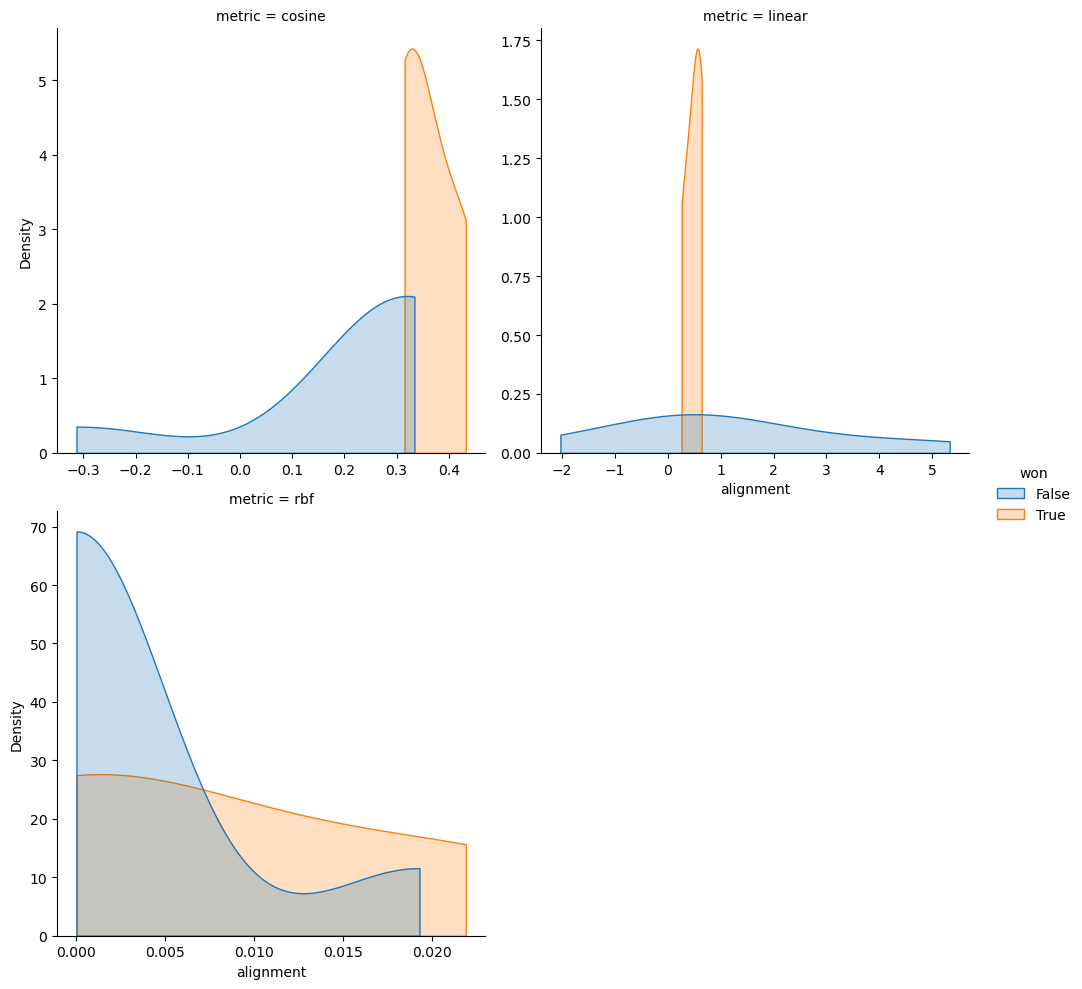

In [102]:
sns.displot(x="alignment", data=desc_aligned, hue='won', col="metric", col_wrap=2, kind="kde", facet_kws={"sharey": False, "sharex": False}, fill=True, cut=0, common_norm=False)

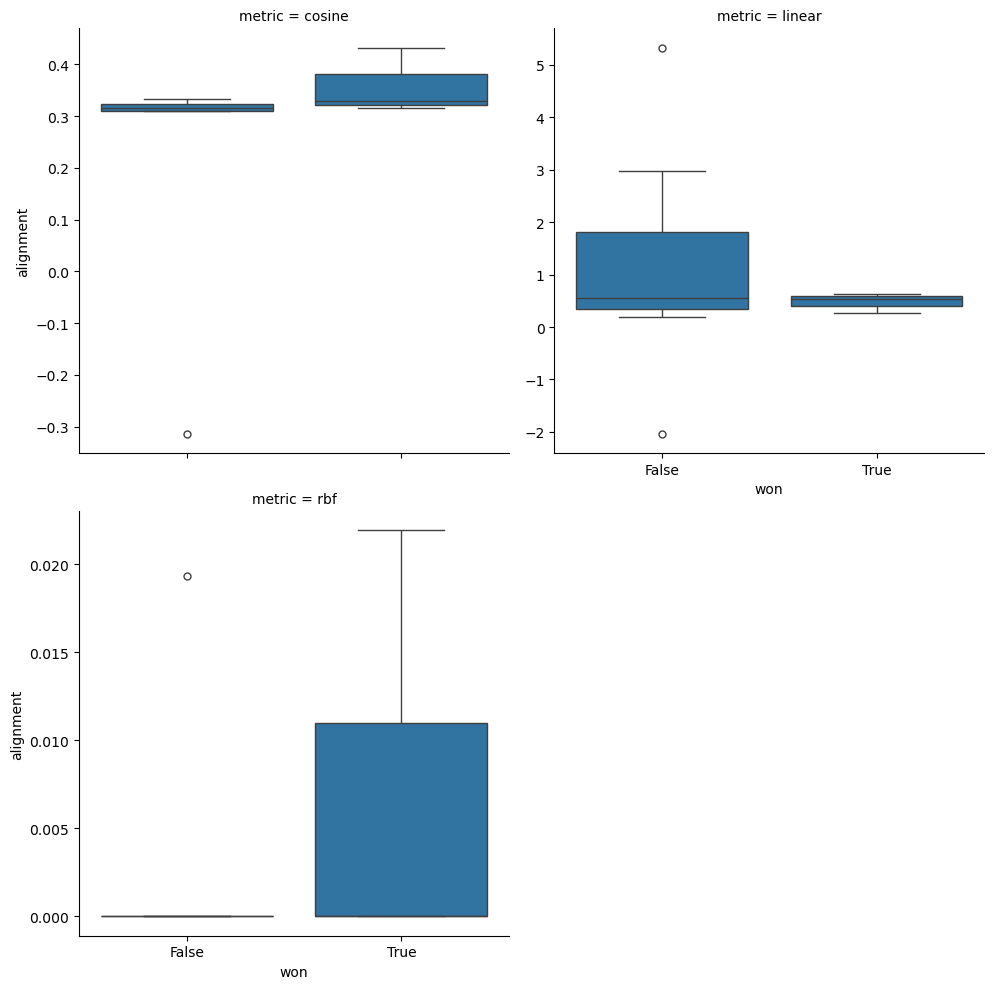

In [103]:
sns.catplot(x="won", y="alignment", data=desc_aligned, kind="box", col="metric", sharey=False, col_wrap=2)

In [76]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_regression(desc_aligned[["alignment", "age", "awards_as_of_year"]], desc_aligned["n_win"])

array([0.02308199, 0.05863488, 0.09448375])

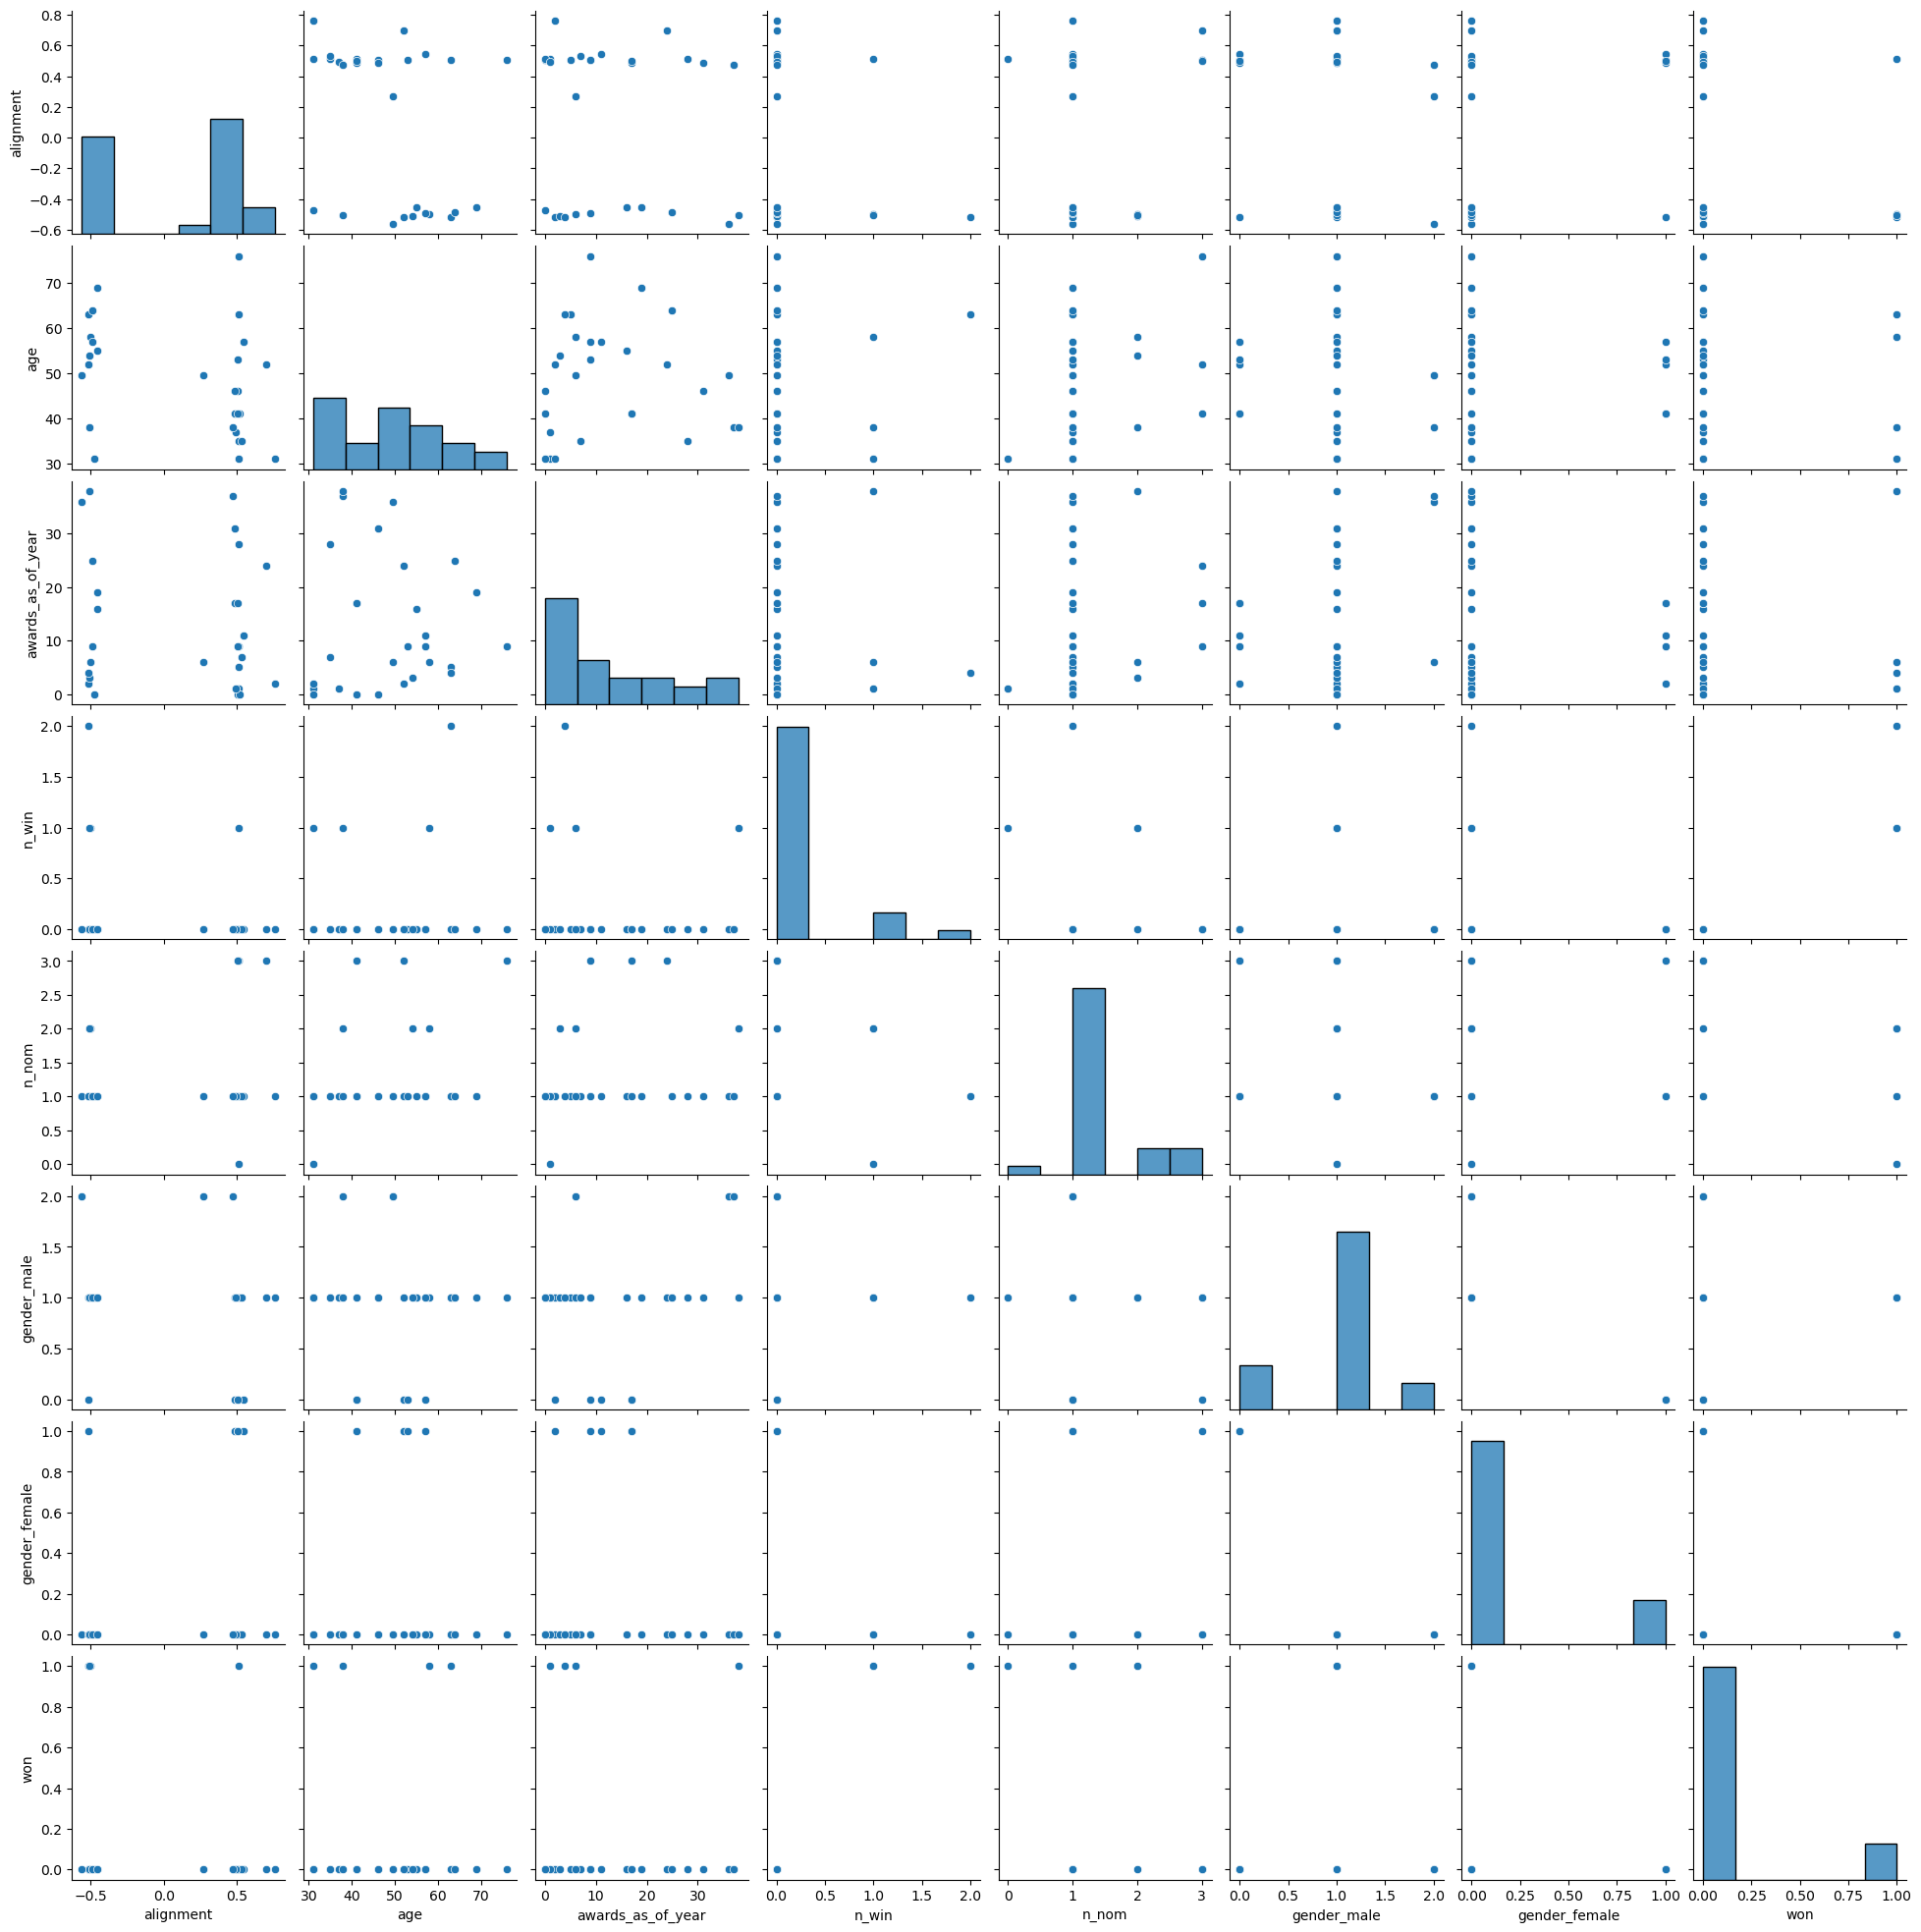

In [13]:
sns.pairplot(desc_aligned[desc_aligned.metric == "cosine"].reset_index().drop(columns=["work_qid", "embedding", "metric"]))

In [14]:
(desc_aligned[desc_aligned.n_win > 0].alignment.mean(), desc_aligned[desc_aligned.n_win == 0].alignment.mean())

(np.float64(-0.23076703604578008), np.float64(0.49468803240778964))